# Experiment analysis

How people fake? For how long? How others succeed (or fail) to detect faked behaviour?

In [1]:
import collections
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns

%matplotlib inline

In [2]:
DATA_DIR = 'data'
SIGNIFICANCE = .05
SIGNIFICANCE_COLOR = '0.9'

## Basic demographics

In [3]:
def get_questionnaires_generator(data_dir):
    """
    Read all questionnaires data from disk.
    """
    for session_dir in os.listdir(data_dir):
        if not session_dir.startswith('session'):
            continue  # Skip the pilot dir
        session_path = os.path.join(data_dir, session_dir)
        for participant_dir in os.listdir(session_path):
            if not participant_dir.startswith('participant'):
                continue
            participant_id = int(participant_dir[len('participant'):])
            with open(os.path.join(data_dir, session_dir, participant_dir, 'questionnaires.json')) as f:
                yield {'participant': participant_id, **json.load(f)}

In [4]:
participants = pd.DataFrame(list(get_questionnaires_generator(DATA_DIR))).set_index('participant')
participants.groupby('gender').agg({'age': ['count', 'mean', 'std']})

age                     
       count       mean       std
gender                           
female     6  27.000000  2.529822
male       6  33.666667  9.709102

## Experiments events

Most of the experiment data comes from the server log file. Preprocessed, it looks like this:

``` 
15:48:12.254 [info] GET /1/participant-id/1
15:48:21.245 [info] GET /1/talking/start
15:48:21.267 [info] GET /1/talking/stop
15:49:03.221 [info] GET /1/autopilot/start
17:29:51.849 [info] POST /scores/reset-hard
17:57:35.544 [info] POST /scores/reset-scores
...
```

The code bellow prepare the data to work with convenient `DataFrames`.

In [5]:
def get_logs(data_dir):
    """
    Read all log files from disk.
    """
    logs = {}
    for session_dir in os.listdir(data_dir):
        if not session_dir.startswith('session'):
            continue  # Skip the pilot dir
        session_path = os.path.join(data_dir, session_dir)
        session_number = int(session_dir[-1])
        assert os.path.isdir(session_path), f'{session_path} is not a directory'
        with open(os.path.join(session_path, 'experiment.log')) as f:
            logs[session_number] = f.read().splitlines()
            
    return logs

In [6]:
class Event(collections.namedtuple('Event', ['session', 'timestamp', 'kind', 'data'])):

        __slots__ = ()
        
        def __str__(self):
            data_str = ' '.join(f'{key}={val}' for key, val in self.data.items())
            return f'{self.timestamp.time()} [{self.session}] {self.kind}: {data_str}'


def parse_player_event(url):
    player, *raw_event = url[1:].split('/')
    
    data = {'player': int(player)}
    
    kind = raw_event[0].replace('-', '_')
    
    if kind == 'participant_id':
        data['participant'] = int(raw_event[1])
    elif kind in ['talking', 'autopilot']:
        data['start'] = raw_event[1] == 'start'
    elif kind == 'accuse':
        data['accused_player'] = int(raw_event[1])
        data['correct'] = raw_event[2] == 'correct'
    elif kind == 'collect_token':
        pass  # Nothing to do here
    else:
        raise AssertionError(f"Event of kind {kind} was not expected")

    return kind, data


def parse_log_line(session, line):
    """
    Parse line to an Event.
    """
    timestamp, _, http_method, url = line.split()
    timestamp = datetime.datetime.strptime(timestamp, '%H:%M:%S.%f')

    if http_method == 'GET':
        kind, data = parse_player_event(url)
    elif http_method == 'POST':
        kind = 'reset_scores'
        data = {'hard': url.endswith('reset-hard')}
    else:
        raise AssertionError(f'{http_method} requests were not expected!')

    return Event(session, timestamp, kind, data)

In [7]:
def to_fractional_seconds(timedelta):
    return timedelta.seconds + timedelta.microseconds / 1_000_000

In [8]:
def add_participant_id(events):
    """
    Run through the events and add participant ID with latest data from events of kind `participant-id`.
    """
    player_id_to_participant_id = {}
    for event in events:
        if event.kind == 'participant_id':
            player_id_to_participant_id[event.data['player']] = event.data['participant']
        else:
            for prefix in ['', 'accused_']:
                player_key = prefix + 'player'
                participant_key = prefix + 'participant'
                if player_key in event.data:
                    event.data[participant_key] = player_id_to_participant_id[event.data[player_key]]

In [9]:
def add_accusation_time_since_faking_started(events):
    """
    The time passed since the accused participant started faking.
    """
    player_id_to_faking_start = {}
    for event in events:
        if event.kind == 'autopilot' and event.data['start']:
            player_id_to_faking_start[event.data['player']] = event.timestamp
        if event.kind == 'accuse' and event.data['correct']:
            start_autopilot = player_id_to_faking_start[event.data['accused_player']]
            event.data['time_since_faking'] = to_fractional_seconds(event.timestamp - start_autopilot)

In [10]:
def add_time(events, kind):
    player_to_start = {}
    for event in events:
        if event.kind == kind:
            player_id = event.data['player']
            if event.data['start']:
                player_to_start[player_id] = event.timestamp
            else:
                delta = event.timestamp - player_to_start[player_id]
                event.data['time'] = to_fractional_seconds(delta)

In [11]:
def add_went_undetected(events):
    autopiloting_and_wasnt_detected = set()  # A set of player IDs
    for event in events:
        if event.kind == 'autopilot':
            if event.data['start']:
                autopiloting_and_wasnt_detected.add(event.data['player'])
            else:
                event.data['went_undetected'] = event.data['player'] in autopiloting_and_wasnt_detected
        elif event.kind == 'accuse' and event.data['correct']:
             if event.data['accused_player'] in autopiloting_and_wasnt_detected:
                    autopiloting_and_wasnt_detected.remove(event.data['accused_player'])

In [12]:
def trim_to_main_task(events):
    last_participant_join = None
    for event in events:
        if event.kind == 'participant_id':
            last_participant_join = event.timestamp
    return [event for event in events if event.timestamp > last_participant_join]

In [13]:
def add_session_length(events):
    first, *_, last = events
    length = last.timestamp - first.timestamp
    for event in events:
        event.data['session_length'] = to_fractional_seconds(length)

In [14]:
def process_logs_to_events(logs):
    all_events = []
    for session, log in logs.items():
        events = [parse_log_line(session, line) for line in log]
        add_participant_id(events)
        add_accusation_time_since_faking_started(events)
        add_went_undetected(events)
        add_time(events, 'talking')
        add_time(events, 'autopilot')
        events = trim_to_main_task(events)
        add_session_length(events)
        all_events += events
    return all_events

In [15]:
logs = get_logs(DATA_DIR)
events = process_logs_to_events(logs)

# Events analysis

In [16]:
def to_dataframe(events, filter_):
    dicts = []
    for event in events:
        if (callable(filter_) and filter_(event)) or event.kind == filter_:
            dicts.append({
                'timestamp': event.timestamp,
                'session': event.session,
                **event.data
            })
    return pd.DataFrame(dicts).set_index('timestamp')

### Accusations

In [17]:
accusations = to_dataframe(events, 'accuse')

In [18]:
print(f'Ratio of correct accusations: {accusations.correct.mean()}')

Ratio of correct accusations: 0.2847682119205298


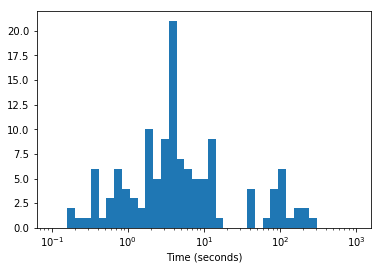

In [19]:
ax = plt.subplot()
ax.hist(accusations.time_since_faking.dropna(), bins=np.logspace(-1, 3, 40))
ax.set_xscale('log')
plt.xlabel('Time (seconds)');

In [20]:
print(f'Mean time of correct accusations since faking started: {accusations.time_since_faking.dropna().mean():.1f}')

Mean time of correct accusations since faking started: 21.2


### Faking

In [21]:
faking = to_dataframe(events, filter_=lambda e: e.kind == 'autopilot' and not e.data['start'])

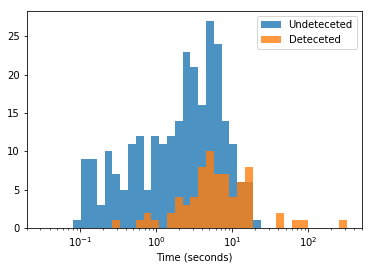

In [22]:
ax = plt.subplot()
kwargs = {'bins': np.logspace(-1.5, 2.5, 40), 'alpha': .8}
ax.hist(faking.time[faking.went_undetected == True], label='Undeteceted', **kwargs)
ax.hist(faking.time[faking.went_undetected == False], label='Deteceted', **kwargs)
ax.set_xscale('log')
plt.xlabel('Time (seconds)')
plt.legend();

In [23]:
print(f'Ratio of undetected faking behaviours: {faking.went_undetected.mean():.3f}')

Ratio of undetected faking behaviours: 0.787


### Per participant checks

To see if participant 9 / participant 13 (that are the same person) looks normal.

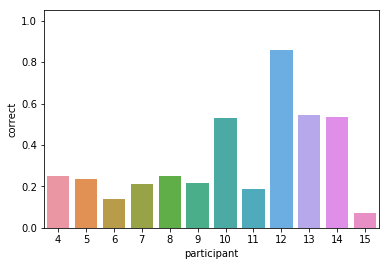

In [24]:
sns.barplot(x='participant', y='correct', errwidth=0, data=accusations);

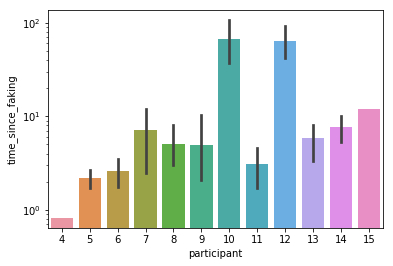

In [25]:
ax = sns.barplot(x='participant', y='time_since_faking', data=accusations);
ax.set_yscale('log')

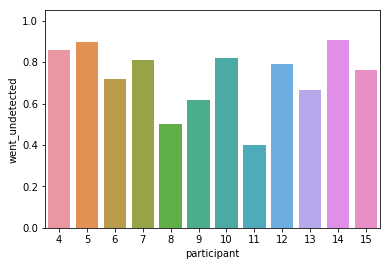

In [26]:
sns.barplot(x='participant', y='went_undetected', errwidth=0, data=faking);

## Participants stats

Compare how much players talk to how much they autopilt. Does faking affect their performance in the conversation? Other pairwise relationships in the participants stats? Gender vs. everything else?

Talking: ratio of talking portions (vs. silence from session length)

In [27]:
talking = to_dataframe(events, filter_=lambda e: e.kind == 'talking' and not e.data['start'])
aggregations = {'time': 'sum', 'session_length': 'first'}
participants_talking = talking.groupby(by='participant').agg(aggregations)

# Add the data to the participants (the questionnaires) dataframe.
participants['talking_ratio'] = participants_talking.time / participants_talking.session_length

Accusations: correct, time from autopilot, and per second

In [28]:
aggregations = {'correct': 'mean', 'time_since_faking': 'mean', 'session_length': 'first', 'session': 'count'}
participants_accusations = accusations.groupby(by='participant').agg(aggregations).rename(columns={'session': 'count'})

participants['accusations_per_sec'] = participants_accusations['count'] / participants_accusations['session_length']
participants['accusations_correct'] = participants_accusations['correct']
participants['accusations_time_since_faking'] = participants_accusations['time_since_faking']

Faking: went undetected, time, and ratio (from session length)

In [29]:
aggregations = {'went_undetected': 'mean', 'time': ['mean', 'sum'], 'session_length': 'first'}
participants_faking = faking.groupby(by='participant').agg(aggregations)

participants['faking_went_undetected'] = participants_faking['went_undetected']
participants['faking_time'] = participants_faking.time['mean']
participants['faking_ratio'] = participants_faking.time['sum'] / participants_faking.session_length['first']

In [30]:
def corrfunc(x, y, **kws):
    (r, p) = sps.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p), xy=(.1, .8), xycoords=ax.transAxes)
    
    if p < SIGNIFICANCE:
        ax.set_facecolor(SIGNIFICANCE_COLOR)

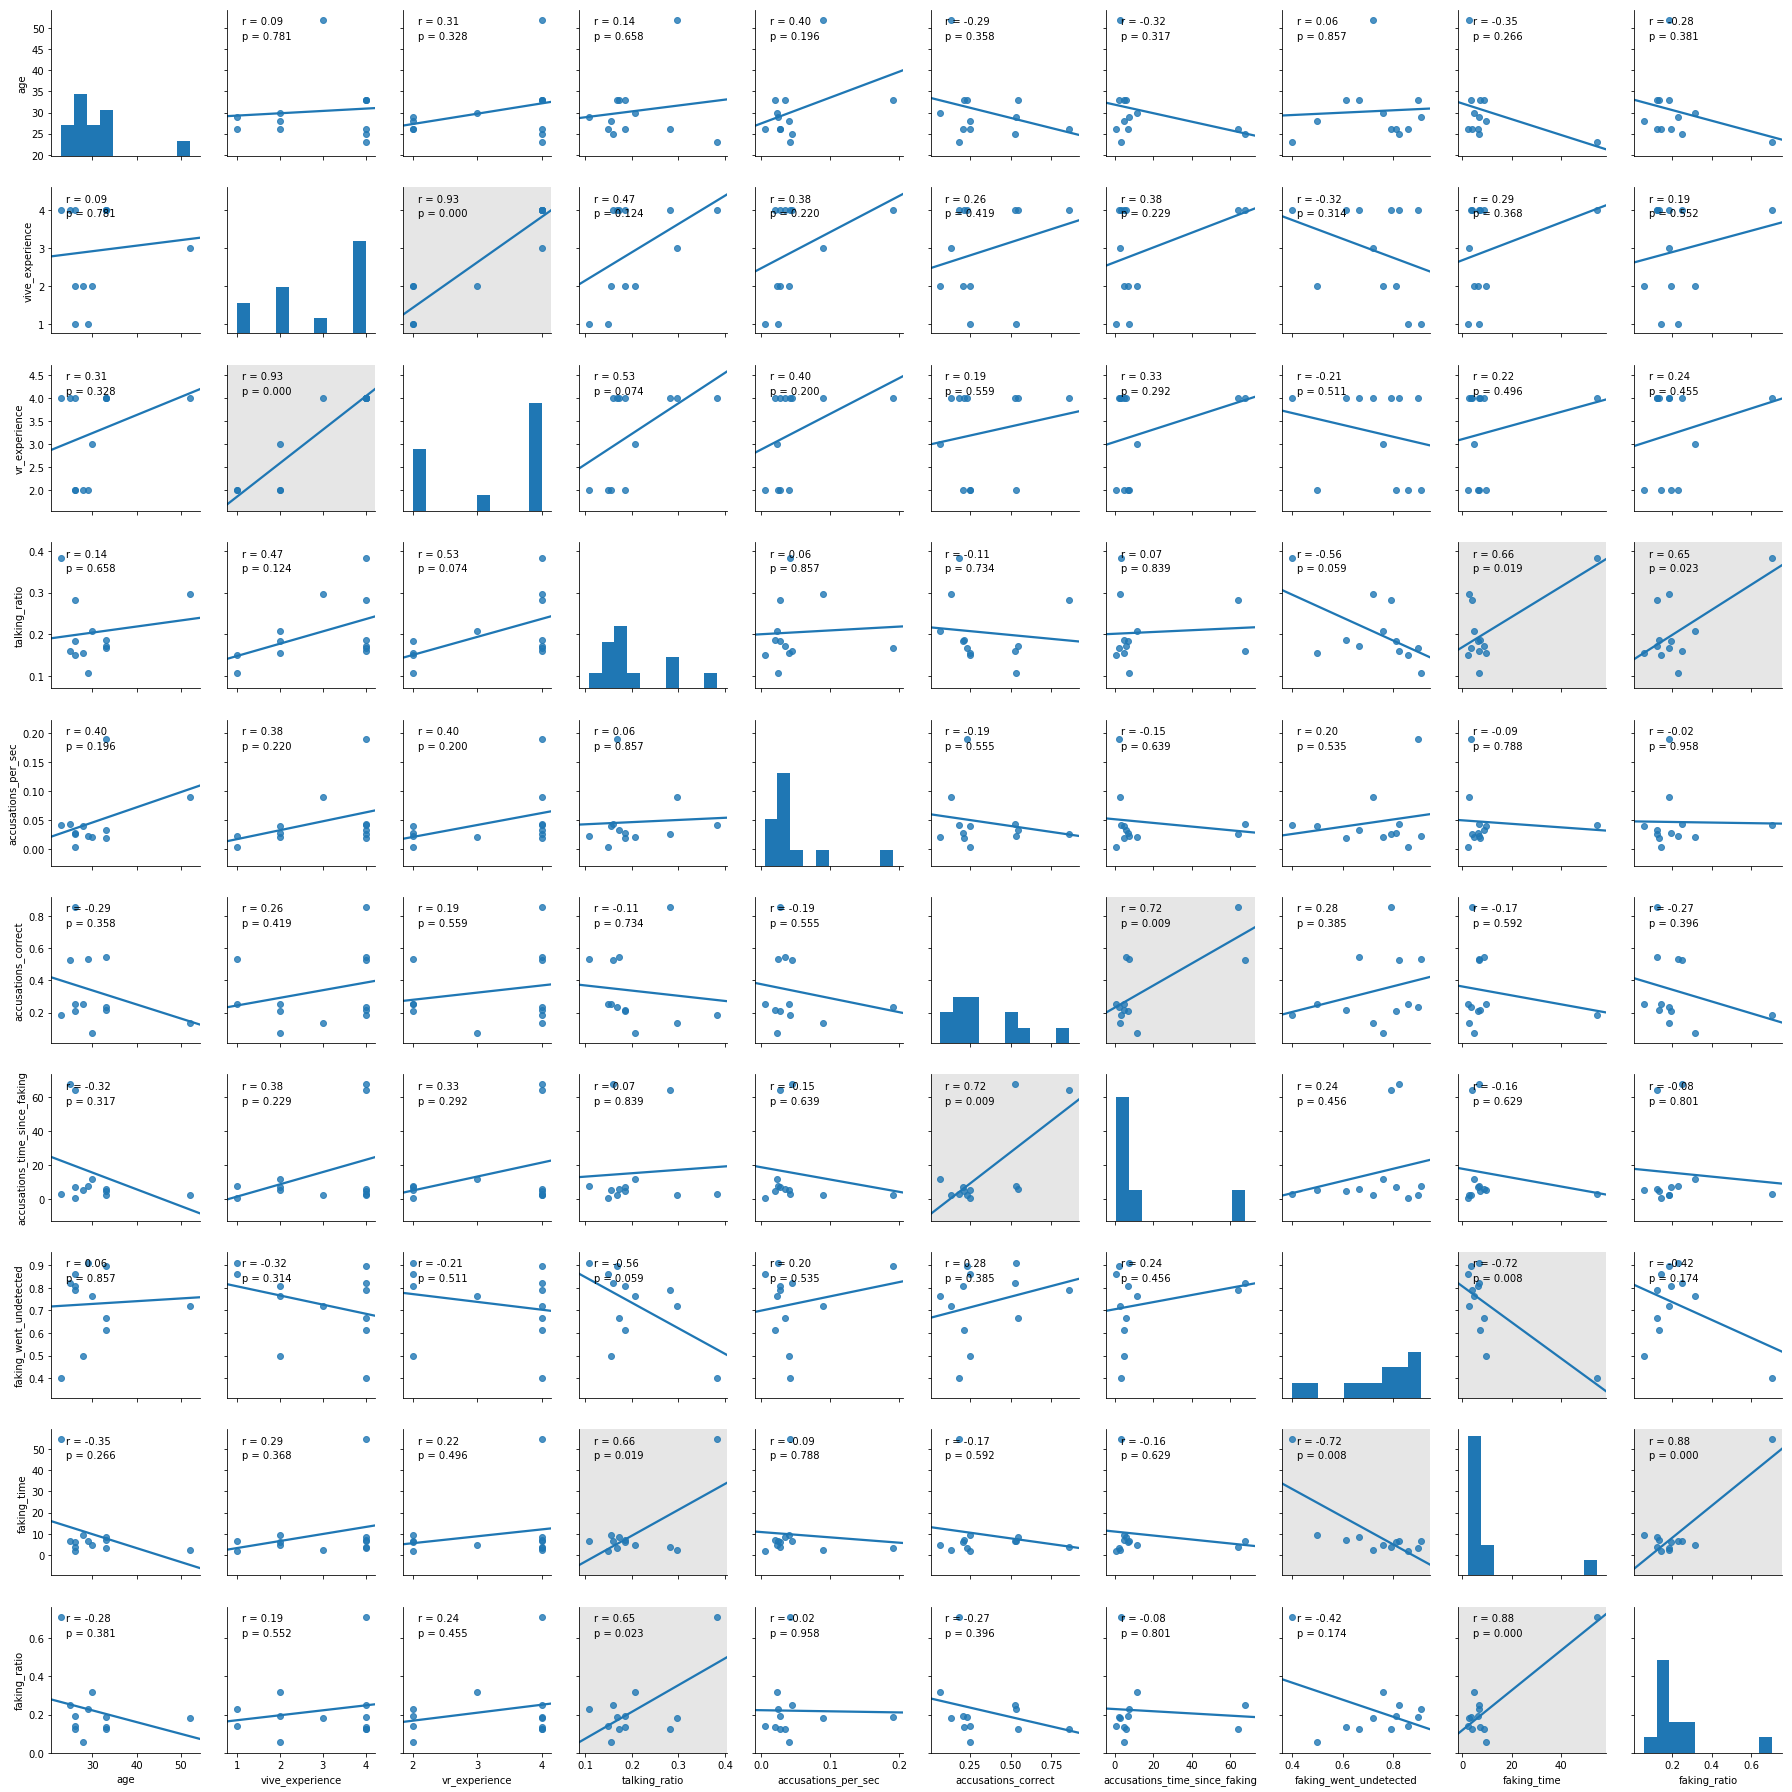

In [31]:
g = sns.pairplot(participants, kind='reg', plot_kws={'ci': None})
g.map_offdiag(corrfunc)
plt.tight_layout()

### Gender

In [32]:
def numerical_columns(df):
    for name, dtype in zip(df.columns, df.dtypes):
        if dtype in [np.int, np.float]:
            yield name

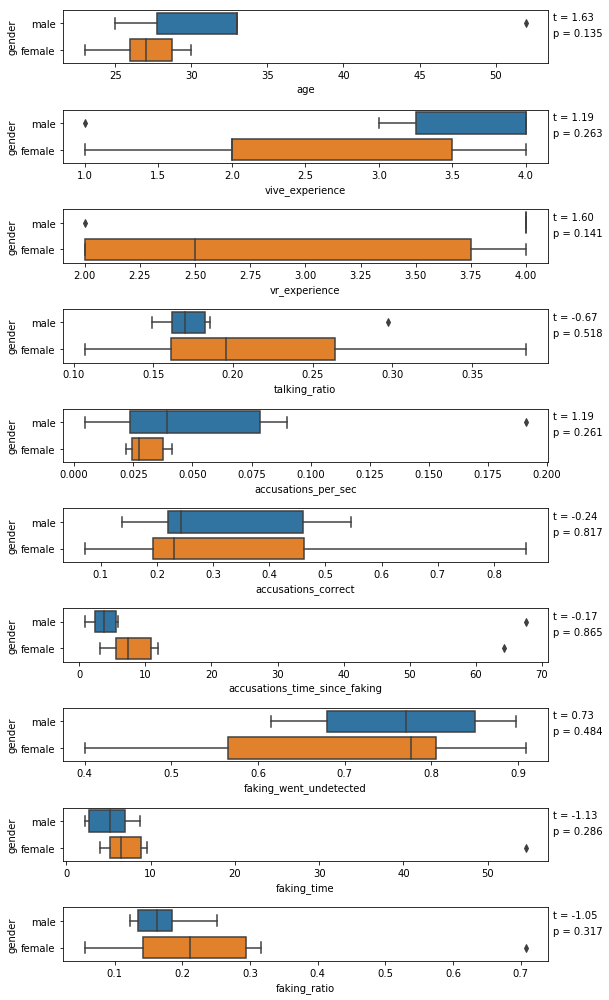

In [33]:
args = list(numerical_columns(participants))

_, axes = plt.subplots(nrows=len(args), ncols=1, figsize=(8, 14))

for arg, ax in zip(args, axes):
    
    (t, p) = sps.ttest_ind(
        participants[arg][participants.gender == 'male'],
        participants[arg][participants.gender == 'female'],
    )
    ax.annotate("t = {:.2f}".format(t), xy=(1.01, .8), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p), xy=(1.01, .5), xycoords=ax.transAxes)
    
    sns.boxplot(x=arg, y='gender', ax=ax, data=participants)

    if p < SIGNIFICANCE:
        ax.set_facecolor(SIGNIFICANCE_COLOR)
    
plt.tight_layout()

## Familiarity effects

Is it easier to detect when someone familiar is faking? Is the detection faster? Who are accused more, familiar or unfamiliar participants?

In [34]:
def get_familiarity(participants, participant, coparticipant):
    """
    Get the participants DataFrame and return the familiairity
    between two participants (directed).
    """
    row = participants.loc[participant]
    for potential_coparticipant, rating in row.familiarity:
        if potential_coparticipant == coparticipant:
            return rating
    raise ValueError(f'No familiarity value between participant {participant} and {coparticipant}')

In [35]:
accusations['familiarity'] = accusations.apply(
    lambda x: get_familiarity(participants, x.participant, x.accused_participant),
    axis=1,
)

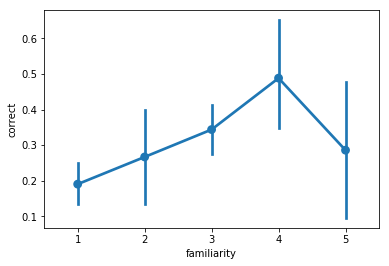

In [36]:
sns.pointplot(x='familiarity', y='correct', data=accusations);

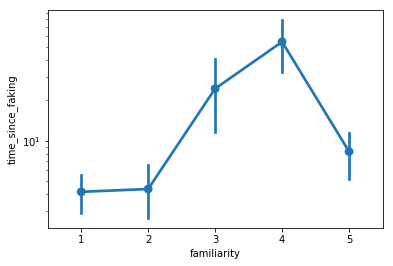

In [37]:
ax = sns.pointplot(x='familiarity', y='time_since_faking', data=accusations);
ax.set_yscale('log')